# Download Event Data
Searches for events greater than given magnitude and downloads specified components, resamples to specified rate, removes instrument response, and saves as SAC file.

##### JBR - 2/3/18
##### JBR - 2/7/18 : Include option to use GCMT parameters in SAC headers

In [2]:
%load_ext autoreload
%autoreload
from setup_parameters import *
import matplotlib.pyplot as plt
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.core import AttribDict
from obspy.io.sac import SACTrace
from obspy.geodetics import gps2dist_azimuth, locations2degrees
import numpy as np
import os
from datetime import datetime
import calendar


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
if not os.path.exists(search_dir):
    os.makedirs(search_dir)
    
# LOAD CLIENT
client = Client(webservice)
print(client)

FDSN Webservice Client (base url: http://service.iris.edu)
Available Services: 'dataselect' (v1.1.5), 'event' (v1.1.8), 'station' (v1.1.32), 'available_event_catalogs', 'available_event_contributors'

Use e.g. client.help('dataselect') for the
parameter description of the individual services
or client.help() for parameter description of
all webservices.


In [4]:
# LOAD EVENT CATALOGUE
t1 = UTCDateTime(tstart)
t2 = UTCDateTime(tend)
catIRIS = client.get_events(starttime=t1, endtime=t2, minmagnitude=minmagnitude)

/Users/russell/anaconda/lib/python3.5/site-packages/obspy/imaging/maps.py:402: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(water_fill_color)
/Users/russell/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/russell/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1710: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/Users/russell/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/russell/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3245: MatplotlibDeprecationWarning: a

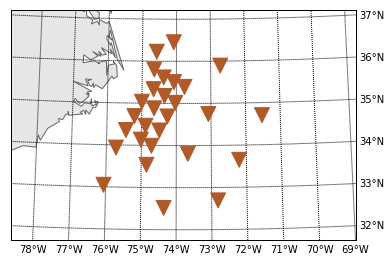

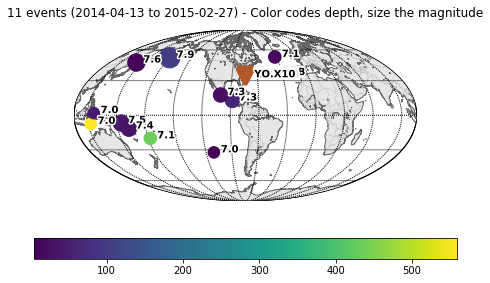

In [5]:
# LOAD STATIONS
inventory = client.get_stations(network=network, station=stations, channel=comps[0], starttime=t1, endtime=t2)
inventory.plot(projection="local",label=False)
fig = inventory.plot(method="basemap", show=False) 
catIRIS.plot(method="basemap", fig=fig)  
fig.savefig(search_dir+"events.pdf", bbox_inches="tight")



In [22]:
# Get event times
f = open(search_dir+'evlist.txt','w')
for iev in range(0,len(catIRIS)) :
    if isCMT_params: # Get GCMT parameters?
        if iscentroid: # Use centroid parameters
            ior = 1
        else: # Use epicentral parameters
            ior = 0
        time = catIRIS[iev].origins[0].time
        date = datetime.strptime(str(time),'%Y-%m-%dT%H:%M:%S.%fZ')
        month = calendar.month_abbr[date.month].lower()
        year = str(date.year)
        time1 = str(time-50)
        time2 = str(time+50)
        catCMT = obspy.read_events("https://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/"+year+"/"+month+""+year[2:4]+".ndk")
        cat_filt = catCMT.filter("time > "+time1,
                                 "time < "+time2,
                                 "magnitude >= "+str(minmagnitude-1))
        if len(cat_filt)==0:
            print('Could not find event in GCMT catalogue... using IRIS parameters instead')
            cat = catIRIS[iev].copy()
            ior = 0
        else:
            cat = cat_filt[0].copy()
    else: # use default IRIS locations
        ior = 0
        cat = catIRIS[iev].copy()
    
    # Define earthquake parameters
    tbeg = cat.origins[ior].time
    tend = tbeg + trlen
    evdp = cat.origins[ior].depth
    evla = cat.origins[ior].latitude
    evlo = cat.origins[ior].longitude 
    mag = cat.magnitudes[0].mag
    
    # extract date for naming folders
    date = datetime.strptime(str(tbeg),'%Y-%m-%dT%H:%M:%S.%fZ')
    evname = date.strftime('%Y%m%d%H%M')
    evdir = search_dir + evname + '/'
    f.write(evname+'\n')
    if not os.path.exists(evdir):
        os.makedirs(evdir)
        print('Working on : ',evname)
        
    else:
        print('Skipping '+evname+'...')
        continue
    
    # Loop through stations
    for ista in range(0,len(inventory[0])) :
        stel = inventory[0].stations[ista].elevation
        stla = inventory[0].stations[ista].latitude
        stlo = inventory[0].stations[ista].longitude
        station = inventory[0].stations[ista].code
        vals = gps2dist_azimuth(lat1=stla, lon1=stlo, lat2=evla, lon2=evlo)
        dist = vals[0]
        baz = vals[1]
        az = vals[2]
        gcarc = locations2degrees(lat1=stla, long1=stlo, lat2=evla, long2=evlo)
    
        # Loop through components
        for icomp, comp in enumerate(comps):   
            try:
                st = client.get_waveforms(network=network, station=station, location="*", channel=comp, starttime=tbeg, endtime=tend, attach_response=True)
            except Exception:
                print('Missing data for station: ',station)
                continue
            if len(st) > 1: # Check for data gaps and fill with 0's
                st.merge(method=1, fill_value=0)
            sr = st[0].stats.sampling_rate
            st.remove_response(output="DISP", zero_mean=True, taper=True, taper_fraction=0.05, pre_filt=[0.001, 0.005, sr/3, sr/2], water_level=60)
            st.trim(starttime=tbeg, endtime=tend, pad=True, nearest_sample=False, fill_value=0) # make sure correct length
            st.detrend(type='demean')
            st.detrend(type='linear')
            st.taper(type="cosine",max_percentage=0.05)
#             sr_old = st[0].stats.sampling_rate
            if is_downsamp==1:
                st.filter('lowpass', freq=0.4*sr_new, zerophase=True) # anti-alias filter
                st.resample(sampling_rate=sr_new)
                st.detrend(type='demean')
                st.detrend(type='linear')
                st.taper(type="cosine",max_percentage=0.05)
    
            # convert to SAC and fill out station/event header info
            sac = SACTrace.from_obspy_trace(st[0])
            sac.stel = stel
            sac.stla = stla
            sac.stlo = stlo
            sac.evdp = evdp
            sac.evla = evla
            sac.evlo = evlo
            sac.mag = mag
            sac.dist = dist
            sac.az = az
            sac.baz = baz
            sac.gcarc = gcarc
            
            sac_out = evdir + evname + '.' + network + '.' + station + '.' + comp + '.sac'
            sac.write(sac_out)
f.close()

Working on :  201502271345
Missing data for station:  C06
Missing data for station:  C06
Missing data for station:  C06
Working on :  201502131859
Missing data for station:  C06
Missing data for station:  C06
Missing data for station:  C06
Working on :  201411150231
Could not find event in GCMT catalogue... using IRIS parameters instead
Working on :  201411091438
Working on :  201411011857
Working on :  201410140351
Working on :  201410090214
Working on :  201406232053
Working on :  201404191328
Working on :  201404181427
Working on :  201404131236
